## 동적 자산배분

장세에 맞게 자산군을 선택하고, 포트폴리오 비중을 조정하는 전략이다.

이전에 평균모멘텀스코어를 기준으로 포트폴리오 비중을 정했는데,
여기에 장세에 맞게 자산군을 선택하는 것 까지 추가됐다.

* 듀얼 모멘텀
* GTAA
* FAA
* VAA
* DAA

In [46]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [47]:
def getCloseData(ticker, start, end=None):
    """
    종가 데이터
    ticker: 종목 번호
    start: 시작일
    end: 마지막 날짜
    return: 종목의 종가 데이터
    """
    return fdr.DataReader(ticker, start, end)['Close']

def getDayReturn(closeDataSet):
    """
    개별종목 일별 수익률
    closeDataSet: 종가 데이터
    return: 종가 데이터의 일별 수익률
    """
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)

def getCumulativeReturn(closeDataSet=None):
    """
    개별종목 누적수익률 == 자산흐름
    closeDataSet: 종가 데이터
    return:종가데이터 누적수익률
    """
    return closeDataSet / closeDataSet.iloc[0]

def getPortfolioResult(closeDataSet, weight=None):
    """
    포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    # 개별종목 일별 수익률
    dayReturn = getDayReturn(closeDataSet)
    # 개별종목 누적 수익률
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    # 자산별 비중. 기본값: 동일비중
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
        
    # 포트폴리오 누적 수익률
    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    # 포트폴리오 일별 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)
        
#     # 자산별 비중이 반영된 개별자산 누적 수익률
#     weightedCumulativeReturn = weight * cumulativeReturn
#     # 자산흐름 정규화: 시기별 각 자산 보유 비율
#     normalizedAssetFlow = weightedCumulativeReturn.divide(weightedCumulativeReturn.sum(axis=1), axis=0) # 각 행의 합으로 각 행을 나누기
#     # 자산별 비중이 반영된 개별자산 일별 수익률
#     weightedDayReturn = normalizedAssetFlow * dayReturn.shift(-1).fillna(0)
#     # 포트폴리오 일별 수익률 = 자산별 비중이 반영된 개별자산 일별 수익률의 합
#     portfolioDayReturn = weightedDayReturn.sum(axis=1).shift(1).fillna(1)
#     # 포트폴리오 누적 수익률
#     portfolioCumulativeReturn = portfolioDayReturn.cumprod()
# #     portfolioCumulativeReturn = weightedCumulativeReturn.sum(axis=1)
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getEvaluation(cumulativeReturn):
    """
    cagr, dd, mdd
    투자 성과 지표
    """
    # cagr
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    # mdd
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()
    
    print(f"cagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd

def getRebalancingDate(closeDataSet, period="month"):
    """
    리밸런싱 일자 추출
    월별, 분기별, 연별
    """
    data = closeDataSet.copy()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
        
    if period == "quarter":
        # 3 6 9 12월 말에 리밸런싱
        # np where 같은걸로 3, 6, 9, 12월 데이터만 가져오고
        # drop_duplicates keep last 하면 됌
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index
        
    return rebalancingDate

def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):
    """
    리밸런싱 포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    
    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                              index=rebalancingDate,
                              columns=closeDataSet.columns)
    
    # 만약, weightDf에 모든 종목이 0으로 잡히는 구간이 있다면
    noWeight = weightDf.sum(axis=1) == 0
    if not weightDf.loc[noWeight].empty :
        # weightDf에 모든 종목이 0인 구간에서는 cash 컬럼을 추가하여 1로 설정한다.
        weightDf['cash'] = np.where(noWeight, 1, 0)
        # 첫 투자 비중은 현금을 제외한 동일비중
        firstWeight = [1/(len(weightDf.columns)-1)] * len(weightDf.columns)
        firstWeight[-1] = 0
        weightDf.iloc[0] =  firstWeight
        # closeDataSet에 cash컬럼을 추가하여 1로 설정한다.
        closeDataSet['cash'] = 1
        
    closeDataSet = closeDataSet.loc[weightDf.iloc[0].name:] # 데이터셋 일자를 weightDf에 맞춘다.
    rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
      
    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성
    
    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영

        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가
    
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터 제거
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1) # 포트폴리오 일간 수익률
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getAvgMomentum(closeDataSet, n=12):
    """
    평균 모멘텀 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 평균 모멘텀 df
    """
    n = 12
    avgMomentum = 0 # 초기값
    dataSetOnRebalancingDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] 
    
    # 1~n개월 모멘텀 합 계산
    for i in range(1, n+1): 
        avgMomentum = dataSetOnRebalancingDate / dataSetOnRebalancingDate.shift(i) + avgMomentum
        
    avgMomentum = pd.DataFrame(avgMomentum) # dataframe으로 변환
    avgMomentum = (avgMomentum / 12).fillna(0) # 평균화
    return avgMomentum

def getWeightByAvgMomentumScore(closeDataSet, n = 12):
    """
    평균 모멘텀 스코어를 기반으로 한 투자 비중 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 투자비중 weight df, 평균모멘텀 스코어 df
    """
    avgMomentumScore = 0 # 초기값
    dataSetOnRebalancingDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] 
    
    # 1 ~ n개월 모멘텀 스코어 합
    for i in range(1, n+1):
        avgMomentumScore = np.where(dataSetOnRebalancingDate / dataSetOnRebalancingDate.shift(i) > 1, 1, 0) + avgMomentumScore
        
    avgMomentumScore = pd.DataFrame(avgMomentumScore, index=dataSetOnRebalancingDate.index, columns=dataSetOnRebalancingDate.columns) # dataframe 형변환
    avgMomentumScore = avgMomentumScore / 12 # 평균화
    weight = avgMomentumScore.divide(avgMomentumScore.sum(axis=1), axis=0).fillna(0) # 모멘텀 스코어에 따른 weight 계산
    return weight, avgMomentumScore

## 데이터 준비

In [48]:
tickers = ['VTI','VEA','BND','HYG','SHY','SHV','IWM','VWO','GLD','TLT','QQQ','EEM','SPY','DBC','VGK','GSG','VNQ','UST','EFA','IEF','EWJ','AGG','LQD']

In [49]:
def updateDataSet():
    """
    자산배분데이터 최신화
    from datetime import timedelta
    from time import sleep
    """
    data = pd.read_csv("동적자산배분데이터.csv", index_col=0, parse_dates=True)
    tickers = data.columns

    start = data.index[-1]+timedelta(days=1)

    newDf = pd.DataFrame()

    for ticker in tickers:
        newData = getCloseData(ticker, start)
        newDf = pd.concat([newDf, newData], axis=1)
        sleep(3)

    newDf.columns = tickers
    newDf.index = pd.to_datetime(newDf.index)
    updatedData = pd.concat([data, newDf])
    updatedData.to_csv("동적자산배분데이터.csv")
    return updatedData

In [50]:
# data = updateDataSet() # 데이터 최신화

In [51]:
data = pd.read_csv("동적자산배분데이터.csv", index_col=0, parse_dates=True)
data

,SHY,GSG,TLT,SPY,VTI,BND,VNQ,VWO,VEA,EWJ,...,HYG,VGK,SHV,UST,IWM,EEM,LQD,IEF,AGG,DBC
2009-01-02,74.71815,29.61,82.52249,72.54897,36.17632,54.50851,21.13848,18.37935,19.22968,31.71652,...,34.46859,25.02595,103.7816,NaN,42.24755,20.46180,63.88389,75.41508,74.28091,21.93
2009-01-05,74.86900,30.63,80.39471,72.46313,36.16846,54.27989,20.74913,18.67543,18.94444,30.92608,...,36.13357,24.76346,103.8569,NaN,42.39898,20.72774,64.32201,75.28307,75.46452,22.16
2009-01-06,74.90449,31.20,79.58615,72.94700,36.46711,53.93349,21.78539,19.00852,19.11141,30.62966,...,36.43835,25.21161,103.9040,NaN,43.11404,21.19705,64.42996,75.23648,75.04128,22.74
2009-01-07,74.85125,29.02,79.89822,70.76178,35.44540,54.09976,21.05462,18.00184,18.88182,30.33324,...,35.77874,24.75066,103.9229,NaN,41.84376,19.97685,63.89024,75.25201,74.35264,21.58
2009-01-08,74.86900,28.62,79.83439,71.05054,35.60259,54.00970,20.89888,17.89081,19.10445,30.76140,...,35.26014,25.02595,103.8099,NaN,42.04565,19.89081,64.34741,75.45390,73.78593,21.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-27,82.55000,23.94,111.60000,388.59000,194.59000,74.47000,92.98000,42.22000,41.50000,53.23000,...,74.58000,53.97000,110.0000,52.16,175.74000,40.70000,109.08000,100.58000,100.60000,27.64
2022-06-28,82.53000,24.23,112.12000,380.65000,190.58000,74.51000,91.85000,41.94000,41.28000,53.15000,...,73.76000,53.44000,110.0500,52.18,172.44000,40.45000,109.05000,100.71000,100.64000,27.97
2022-06-29,82.63000,23.79,113.87000,380.34000,190.26000,74.94000,91.28000,41.83000,41.03000,52.91000,...,73.65000,53.13000,110.0700,53.03,170.69000,40.29000,109.70000,101.52000,101.22000,27.49
2022-06-30,82.79000,23.10,114.87000,377.25000,188.62000,75.26000,91.11000,41.65000,40.80000,52.83000,...,73.61000,52.82000,110.1000,53.88,169.36000,40.10000,110.03000,102.30000,101.68000,26.64


### PAA 자산

SPY(S&P500), QQQ(나스닥), IWM(미소형주), VGK(유럽주식), EWJ(일본주식), EEM(개도국주식), VNQ(미부동산), GLD(금), DBC(원자재), HYG(고금리채), LQD(회사채), TLT(미장기채)

## PAA (보수적인 전략, 낌새가 이상하면 재빠르게 도망가겠다.)

https://www.youtube.com/watch?v=MvpcevwtcUo

투자전략

---

1. 자산 유니버스 설정

2. 광폭 모멘텀으로 안전자산 비중 설정
12개 자산 유니버스 중 현재 가격이 12개월 단순 이평보다 낮은 자산을 하락추세로 판단.  
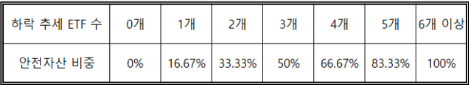

3. 안전자산 비중만큼 미국 중기채 IEF에 투자

4. 그 외 투자금은 상대 모멘텀 6개 ETF에 분산투자.
매월 말 각 ETF의 12개월 단순이평 계산 (


## GTAA

투자전략

---

1. 투자 대상:  SPY(미국 대형주), EFA(선진국 주식), IEF(미국 중기채), DBC(원자재), VNQ(미국 리츠)


2. 5개 자산에 각 20% 비중으로 투자하되, 모멘텀 스코어 0 미만인 자산의 비중만큼은 현금 보유
* 모멘텀 스코어 = (가격 / 10개월(200일) 이동평균) - 1

In [52]:
# 데이터 준비
gtaaCol = ['SPY', 'EFA', "IEF", "DBC", "VNQ"]
gtaaData = data[gtaaCol].copy()
gtaaData

,SPY,EFA,IEF,DBC,VNQ
2009-01-02,72.54897,45.44,75.41508,21.93,21.13848
2009-01-05,72.46313,44.71,75.28307,22.16,20.74913
2009-01-06,72.94700,45.19,75.23648,22.74,21.78539
2009-01-07,70.76178,44.41,75.25201,21.58,21.05462
2009-01-08,71.05054,45.07,75.45390,21.66,20.89888
...,...,...,...,...,...
2022-06-27,388.59000,63.50,100.58000,27.64,92.98000
2022-06-28,380.65000,63.07,100.71000,27.97,91.85000
2022-06-29,380.34000,62.83,101.52000,27.49,91.28000
2022-06-30,377.25000,62.49,102.30000,26.64,91.11000


In [53]:
# 모멘텀 스코어 계산
# 5개 자산에 각 20% 비중으로 투자하되, 모멘텀 스코어 0 미만인 자산의 비중만큼은 현금 보유
# 모멘텀 스코어 = (가격 / 10개월 이동평균) - 1

ma200 = gtaaData.rolling(window=200).mean()
momentumScore = (gtaaData / ma200) -1
momentumScore.dropna(inplace=True)
momentumScore = momentumScore.loc['2010':]
momentumScore

,SPY,EFA,IEF,DBC,VNQ
2010-01-04,0.158182,0.139667,-0.018427,0.116468,0.259485
2010-01-05,0.158991,0.138390,-0.013840,0.116721,0.254029
2010-01-06,0.157871,0.141195,-0.017542,0.135513,0.248393
2010-01-07,0.160699,0.134680,-0.017271,0.120300,0.258058
2010-01-08,0.162530,0.141570,-0.015820,0.118261,0.245161
...,...,...,...,...,...
2022-06-27,-0.115332,-0.149974,-0.087319,0.160141,-0.116155
2022-06-28,-0.132769,-0.154707,-0.085471,0.171874,-0.126292
2022-06-29,-0.132821,-0.156851,-0.077469,0.149841,-0.131059
2022-06-30,-0.139209,-0.160345,-0.069742,0.112626,-0.132024


In [54]:
# 리밸런싱 일자
gtaaRebalDate = getRebalancingDate(momentumScore)
gtaaRebalDate

DatetimeIndex(['2010-01-29', '2010-02-26', '2010-03-31', '2010-04-30',
               '2010-05-28', '2010-06-30', '2010-07-30', '2010-08-31',
               '2010-09-30', '2010-10-29',
               ...
               '2021-10-29', '2021-11-30', '2021-12-31', '2022-01-31',
               '2022-02-28', '2022-03-31', '2022-04-29', '2022-05-31',
               '2022-06-30', '2022-07-01'],
              dtype='datetime64[ns]', length=151, freq=None)

In [55]:
# weightDf 계산하기
# 5개 자산에 각 20% 비중으로 투자하되, 모멘텀 스코어 0 미만인 자산의 비중만큼은 현금 보유
weightDf = pd.DataFrame(np.where(momentumScore > 0, 0.2, 0), index=momentumScore.index, columns=gtaaCol) 
weightDf.index = pd.to_datetime(weightDf.index)
weightDf = weightDf.loc[gtaaRebalDate]
weightDf['Cash'] = 1 - weightDf.sum(axis=1)
weightDf

,SPY,EFA,IEF,DBC,VNQ,Cash
2010-01-29,0.2,0.2,0.2,0.0,0.2,0.2
2010-02-26,0.2,0.2,0.2,0.2,0.2,0.0
2010-03-31,0.2,0.2,0.0,0.2,0.2,0.2
2010-04-30,0.2,0.2,0.2,0.2,0.2,0.0
2010-05-28,0.0,0.0,0.2,0.0,0.2,0.6
...,...,...,...,...,...,...
2022-03-31,0.2,0.0,0.0,0.2,0.2,0.4
2022-04-29,0.0,0.0,0.0,0.2,0.0,0.8
2022-05-31,0.0,0.0,0.0,0.2,0.0,0.8
2022-06-30,0.0,0.0,0.0,0.2,0.0,0.8


In [56]:
# 데이터 일자 조정
gtaaData = gtaaData.loc[gtaaRebalDate[0]:]
gtaaData.loc[:,'Cash'] = 1
gtaaData

,SPY,EFA,IEF,DBC,VNQ,Cash
2010-01-29,85.75082,52.48,72.75335,22.69,26.84466,1
2010-02-01,87.08431,53.44,72.50386,23.24,27.33367,1
2010-02-02,88.13833,54.33,72.62458,23.74,27.70836,1
2010-02-03,87.69916,53.76,72.27852,23.45,27.25746,1
2010-02-04,84.99225,51.57,72.87408,22.67,26.24769,1
...,...,...,...,...,...,...
2022-06-27,388.59000,63.50,100.58000,27.64,92.98000,1
2022-06-28,380.65000,63.07,100.71000,27.97,91.85000,1
2022-06-29,380.34000,62.83,101.52000,27.49,91.28000,1
2022-06-30,377.25000,62.49,102.30000,26.64,91.11000,1


In [57]:
gtaaDayReturn, gtaaCumReturn = getRebalancingPortfolioResult(closeDataSet=gtaaData, weightDf=weightDf)
gtaaCagr, gtaaDD, gtaaMDD = getEvaluation(gtaaCumReturn)

cagr: 1.0474538072319464
mdd: 12.068839105085335


<AxesSubplot:>

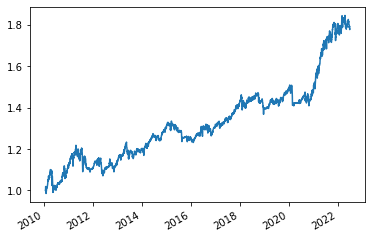

In [58]:
gtaaCumReturn.plot()

#### GTAA 함수화

In [59]:
def getGTAAWeight(closeDataSet):
    # gtaa 전략 종목 유니버스
    gtaaCol = ['SPY', 'EFA', "IEF", "DBC", "VNQ"]
    
    gtaaData = closeDataSet[gtaaCol]
    
    # 모멘텀 스코어 계산
    # 5개 자산에 각 20% 비중으로 투자하되, 모멘텀 스코어 0 미만인 자산의 비중만큼은 현금 보유
    # 모멘텀 스코어 = (가격 / 10개월 이동평균) - 1
    ma200 = gtaaData.rolling(window=200).mean() # 10개월 이동평균, 200일선
    momentumScore = (gtaaData / ma200) -1 # 모멘텀 스코어 계산
    momentumScore.dropna(inplace=True) # 결측치 버리기
    
    # 리밸런싱 일자
    gtaaRebalDate = getRebalancingDate(momentumScore) 
    
    # weightDf 계산하기
    # 5개 자산에 각 20% 비중으로 투자하되, 모멘텀 스코어 0 미만인 자산의 비중만큼은 현금 보유
    weightDf = pd.DataFrame(np.where(momentumScore > 0, 0.2, 0), index=momentumScore.index, columns=gtaaCol) 
    weightDf.index = pd.to_datetime(weightDf.index)
    weightDf = weightDf.loc[gtaaRebalDate]
    weightDf['Cash'] = 1 - weightDf.sum(axis=1)
    return weightDf

## FAA

투자전략 

---

1. 투자 대상: VTI(미국 주식), VEA(선진국 주식), VWO(신흥국 주식), SHY(미국 단기국채), BND(미국 혼합채권), DBC(원자재), VNQ(미국 리츠)


2. 7개 자산의 모멘텀, 변동성, 상관성을 가중평균 평균하여 상위 3개 종목에 투자

* 단, 모멘텀 < 1 인 종목의 비중은 현금에 투자
* 모멘텀 : 4개월 수익률 순위 (높을수록 좋음)
* 변동성 : 4개월 일일수익률의 표준편차(standard deviation) 순위 (낮을수록 좋음)
* 상관성 : 4개월 하나의 자산과 다른 6개 자산간의 일일수익률의 상관성(correlation)의 합 순위 (낮을수록 좋음)
* 가중평균 : (모멘텀 * 1) + (변동성 * 0.5) + (상관성 * 0.5) 값이 낮은 순서대로 순위를 매김

In [60]:
faaCol = ['VTI', 'VEA', 'VWO', 'SHY', 'BND', 'DBC', 'VNQ']
faaData = data[faaCol]
faaData

,VTI,VEA,VWO,SHY,BND,DBC,VNQ
2009-01-02,36.17632,19.22968,18.37935,74.71815,54.50851,21.93,21.13848
2009-01-05,36.16846,18.94444,18.67543,74.86900,54.27989,22.16,20.74913
2009-01-06,36.46711,19.11141,19.00852,74.90449,53.93349,22.74,21.78539
2009-01-07,35.44540,18.88182,18.00184,74.85125,54.09976,21.58,21.05462
2009-01-08,35.60259,19.10445,17.89081,74.86900,54.00970,21.66,20.89888
...,...,...,...,...,...,...,...
2022-06-27,194.59000,41.50000,42.22000,82.55000,74.47000,27.64,92.98000
2022-06-28,190.58000,41.28000,41.94000,82.53000,74.51000,27.97,91.85000
2022-06-29,190.26000,41.03000,41.83000,82.63000,74.94000,27.49,91.28000
2022-06-30,188.62000,40.80000,41.65000,82.79000,75.26000,26.64,91.11000


In [61]:
# 7개 자산의 모멘텀, 변동성, 상관성을 가중평균 평균하여 상위 3개 종목에 투자
# 단, 모멘텀 < 0인 종목의 비중은 현금에 투자

# 리밸런싱 날짜
faaRebalDate = getRebalancingDate(faaData)
faaRebalDate

DatetimeIndex(['2009-01-30', '2009-02-27', '2009-03-31', '2009-04-30',
               '2009-05-29', '2009-06-30', '2009-07-31', '2009-08-31',
               '2009-09-30', '2009-10-30',
               ...
               '2021-10-29', '2021-11-30', '2021-12-31', '2022-01-31',
               '2022-02-28', '2022-03-31', '2022-04-29', '2022-05-31',
               '2022-06-30', '2022-07-01'],
              dtype='datetime64[ns]', length=163, freq=None)

In [62]:
# 모멘텀 : 4개월 수익률
faaRebalData = faaData.loc[faaRebalDate]
momentum4 = faaRebalData / faaRebalData.shift(4)
momentum4Score = momentum4.rank(method="max", axis=1, ascending=False)
momentum4Score

,VTI,VEA,VWO,SHY,BND,DBC,VNQ
2009-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-05-29,4.0,2.0,1.0,7.0,6.0,3.0,5.0
...,...,...,...,...,...,...,...
2022-03-31,3.0,5.0,6.0,4.0,7.0,1.0,2.0
2022-04-29,7.0,6.0,5.0,2.0,3.0,1.0,4.0
2022-05-31,6.0,4.0,7.0,2.0,5.0,1.0,3.0
2022-06-30,7.0,6.0,5.0,2.0,3.0,1.0,4.0


In [63]:
# 변동성 : 4개월 일일수익률의 표준편차(standard deviation) 순위 (낮을수록 좋음)
# 4개월 단위를 뽑아내는 것만 하면 끝.
import warnings
warnings.filterwarnings(action='ignore')

std4 = pd.DataFrame()

reverseFaaRebalDate = faaRebalDate[::-1]

for index, date in enumerate(reverseFaaRebalDate) :
    if index >= len(reverseFaaRebalDate) - 4:
        break
    before4month = reverseFaaRebalDate[index+4]
    # 일일 수익률
    dayReturn = getDayReturn(closeDataSet=faaData)
    
    # 4개월 일일수익률 표준편차
    std = dayReturn.loc[date:before4month:-1].std()
    std.name = date
    std4 = std4.append(std)
    

std4

,VTI,VEA,VWO,SHY,BND,DBC,VNQ
2022-07-01,0.018267,0.014027,0.014273,0.001649,0.005261,0.015240,0.017415
2022-06-30,0.017610,0.014931,0.016815,0.001596,0.005260,0.020295,0.016247
2022-05-31,0.016726,0.014292,0.016728,0.001458,0.004690,0.019362,0.014943
2022-04-29,0.014587,0.012629,0.015575,0.001340,0.004275,0.017958,0.013304
2022-03-31,0.013661,0.012402,0.015116,0.001173,0.003803,0.017572,0.012485
...,...,...,...,...,...,...,...
2009-09-30,0.011447,0.014445,0.017418,0.001237,0.003248,0.015546,0.025654
2009-08-31,0.013388,0.016732,0.020824,0.001252,0.003449,0.016099,0.030887
2009-07-31,0.015564,0.018516,0.023302,0.001270,0.003408,0.016585,0.042139
2009-06-30,0.020967,0.023259,0.028572,0.001323,0.003766,0.018802,0.052868


In [64]:
std4Score = std4.rank(method="first", axis=1, ascending=True)
std4Score = std4Score.sort_index(ascending=True)
std4Score

,VTI,VEA,VWO,SHY,BND,DBC,VNQ
2009-05-29,4.0,5.0,6.0,1.0,2.0,3.0,7.0
2009-06-30,4.0,5.0,6.0,1.0,2.0,3.0,7.0
2009-07-31,3.0,5.0,6.0,1.0,2.0,4.0,7.0
2009-08-31,3.0,5.0,6.0,1.0,2.0,4.0,7.0
2009-09-30,3.0,4.0,6.0,1.0,2.0,5.0,7.0
...,...,...,...,...,...,...,...
2022-03-31,5.0,3.0,6.0,1.0,2.0,7.0,4.0
2022-04-29,5.0,3.0,6.0,1.0,2.0,7.0,4.0
2022-05-31,5.0,3.0,6.0,1.0,2.0,7.0,4.0
2022-06-30,6.0,3.0,5.0,1.0,2.0,7.0,4.0


In [65]:
# 상관성 : 4개월 하나의 자산과 다른 6개 자산간의 일일수익률의 상관성(correlation)의 합 순위 (낮을수록 좋음)
# 가중평균 : (모멘텀 * 1) + (변동성 * 0.5) + (상관성 * 0.5) 값이 낮은 순서대로 순위를 매김

reverseFaaRebalDate = faaRebalDate[::-1]
corr4 = pd.DataFrame()

for index, date in enumerate(reverseFaaRebalDate):
    if index >= len(reverseFaaRebalDate) - 4:
        break
    before4month = reverseFaaRebalDate[index+4]
    
    # 일일 수익률
    dayReturn = getDayReturn(closeDataSet=faaData)

    # 4개월 상관성
    corr = (dayReturn.loc[date:before4month:-1].corr(method="pearson")).sum(axis=1)-1
    corr.name = date
    corr4 = corr4.append(corr)
    
    
corr4

,VTI,VEA,VWO,SHY,BND,DBC,VNQ
2022-07-01,3.298480,3.372295,2.669705,1.630560,1.823168,1.449217,3.108108
2022-06-30,2.762237,2.577599,2.204412,1.251308,1.549762,0.194949,2.605759
2022-05-31,2.387960,2.139964,1.927409,0.776565,1.197969,0.031034,2.194959
2022-04-29,2.151582,1.786992,1.729311,0.937389,1.280959,-0.517284,1.951320
2022-03-31,2.089302,1.796414,1.750931,0.848561,0.870592,-0.492058,2.125781
...,...,...,...,...,...,...,...
2009-09-30,2.645654,2.838076,2.544765,-0.577723,-0.441162,2.275537,2.012756
2009-08-31,2.882286,3.086290,2.824256,-0.239042,-0.023411,2.311037,2.334111
2009-07-31,2.908690,3.140253,2.910901,-0.322777,-0.135217,2.454379,2.454610
2009-06-30,3.082819,3.219992,3.041236,-0.201621,0.282010,2.213572,2.650935


In [66]:
corr4Score = corr4.rank(method="first", axis=1, ascending=True)
corr4Score= corr4Score.sort_index(ascending=True)
corr4Score

,VTI,VEA,VWO,SHY,BND,DBC,VNQ
2009-05-29,6.0,7.0,5.0,1.0,2.0,3.0,4.0
2009-06-30,6.0,7.0,5.0,1.0,2.0,3.0,4.0
2009-07-31,5.0,7.0,6.0,1.0,2.0,3.0,4.0
2009-08-31,6.0,7.0,5.0,1.0,2.0,3.0,4.0
2009-09-30,6.0,7.0,5.0,1.0,2.0,4.0,3.0
...,...,...,...,...,...,...,...
2022-03-31,6.0,5.0,4.0,2.0,3.0,1.0,7.0
2022-04-29,7.0,5.0,4.0,2.0,3.0,1.0,6.0
2022-05-31,7.0,5.0,4.0,2.0,3.0,1.0,6.0
2022-06-30,7.0,5.0,4.0,2.0,3.0,1.0,6.0


In [67]:
# 모멘텀, 표준편차, 상관성 데이터 시점 맞추기
# 2010 ~
momentum4 = momentum4.loc['2010':]
momentum4Score = momentum4Score.loc['2010':]
std4Score = std4Score.loc['2010':]
corr4Score = corr4Score.loc['2010':]

In [68]:
momentum4

,VTI,VEA,VWO,SHY,BND,DBC,VNQ
2010-01-29,1.020829,0.964821,1.005944,1.005586,1.013974,1.028558,1.032940
2010-02-26,1.084479,0.999669,1.050234,1.005832,1.014487,1.001696,1.141561
2010-03-31,1.091702,1.020675,1.060101,0.998375,0.999201,0.953771,1.180351
2010-04-30,1.084469,0.984526,1.025854,1.009874,1.024737,0.992689,1.177750
2010-05-28,1.035917,0.921137,0.998954,1.006445,1.023128,0.967827,1.180071
...,...,...,...,...,...,...,...
2022-03-31,0.975241,0.966398,0.937792,0.971558,0.931164,1.337782,1.015271
2022-04-29,0.856859,0.876812,0.878285,0.969137,0.898997,1.324832,0.895957
2022-05-31,0.909836,0.927073,0.878599,0.981165,0.923855,1.284567,0.932511
2022-06-30,0.852828,0.853735,0.870974,0.979068,0.918701,1.116045,0.888531


In [69]:
# 가중평균

totalScore = (momentum4Score + 0.5 * (std4Score + corr4Score)).rank(method="first", axis=1, ascending=True)

# 모멘텀 1 미만에 대해서는 현금투자,
# 랭킹에서 상위 3가지 뽑아 내는 방법

weight = (totalScore <= 3) & (momentum4 >= 1)
faaWeight = weight.replace(True, 1/3).replace(False, 0)
faaWeight['Cash'] = 1 - faaWeight.sum(axis=1)
faaWeight


,VTI,VEA,VWO,SHY,BND,DBC,VNQ,Cash
2010-01-29,0.000000,0.0,0.0,0.000000,0.333333,0.333333,0.333333,0.000000
2010-02-26,0.333333,0.0,0.0,0.000000,0.333333,0.000000,0.333333,0.000000
2010-03-31,0.333333,0.0,0.0,0.000000,0.000000,0.000000,0.333333,0.333333
2010-04-30,0.333333,0.0,0.0,0.333333,0.333333,0.000000,0.000000,0.000000
2010-05-28,0.333333,0.0,0.0,0.333333,0.333333,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2022-03-31,0.000000,0.0,0.0,0.000000,0.000000,0.333333,0.333333,0.333333
2022-04-29,0.000000,0.0,0.0,0.000000,0.000000,0.333333,0.000000,0.666667
2022-05-31,0.000000,0.0,0.0,0.000000,0.000000,0.333333,0.000000,0.666667
2022-06-30,0.000000,0.0,0.0,0.000000,0.000000,0.333333,0.000000,0.666667


In [70]:
faaData = faaData.loc['2010':]
faaData['Cash'] = 1
faaData

,VTI,VEA,VWO,SHY,BND,DBC,VNQ,Cash
2010-01-04,46.08189,25.02397,31.81075,75.39010,56.76402,25.24,28.29263,1
2010-01-05,46.25879,25.03822,31.91579,75.48085,56.92996,25.27,28.26088,1
2010-01-06,46.32312,25.04535,32.11086,75.48993,56.90831,25.72,28.21007,1
2010-01-07,46.51610,24.99547,31.83326,75.47178,56.86502,25.40,28.51491,1
2010-01-08,46.66887,25.26623,32.02832,75.54438,56.92274,25.38,28.30533,1
...,...,...,...,...,...,...,...,...
2022-06-27,194.59000,41.50000,42.22000,82.55000,74.47000,27.64,92.98000,1
2022-06-28,190.58000,41.28000,41.94000,82.53000,74.51000,27.97,91.85000,1
2022-06-29,190.26000,41.03000,41.83000,82.63000,74.94000,27.49,91.28000,1
2022-06-30,188.62000,40.80000,41.65000,82.79000,75.26000,26.64,91.11000,1


In [71]:
faaDayReturn, faaCumReturn = getRebalancingPortfolioResult(closeDataSet=faaData, weightDf=faaWeight)
print("FAA 전략 최종 수익률")
print(faaCumReturn.iloc[-1])
faaCagr, faaDD, faaMDD = getEvaluation(faaCumReturn)

FAA 전략 최종 수익률
2.2265064999678628
cagr: 1.066609657004269
mdd: 10.671472270752377


<AxesSubplot:>

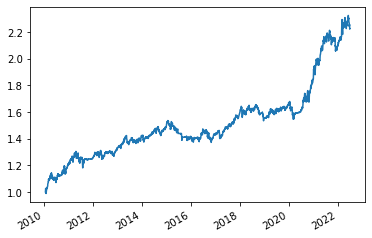

In [72]:
faaCumReturn.plot()

In [73]:
# 걍 평모스 해볼까

avgMomentumWeight, avgMomentumScore = getWeightByAvgMomentumScore(faaData, n=6)
avgMomentumWeight = avgMomentumWeight.loc["2010":]

d, c = getRebalancingPortfolioResult(closeDataSet=faaData, weightDf=avgMomentumWeight)
print(c.iloc[-1])
getEvaluation(c)

# 괜찮은디..

2.250815585087142
cagr: 1.0675431559383257
mdd: 16.223252307436344


(1.0675431559383257,
 2010-01-29    0.000000
 2010-02-01    0.000000
 2010-02-02    0.000000
 2010-02-03    0.669055
 2010-02-04    2.960855
                 ...   
 2022-06-27    7.502195
 2022-06-28    6.945417
 2022-06-29    7.920635
 2022-06-30    9.656730
 2022-07-01    9.215866
 Length: 3128, dtype: float64,
 16.223252307436344)

#### FAA 비중 함수

In [74]:
def getFAAWeight(closeDataSet):
    faaCol = ['VTI', 'VEA', 'VWO', 'SHY', 'BND', 'DBC', 'VNQ']
    faaData = closeDataSet[faaCol]
    
    # 리밸런싱 날짜
    faaRebalDate = getRebalancingDate(faaData)

    # 모멘텀 : 4개월 수익률
    faaRebalData = faaData.loc[faaRebalDate] # 리밸런싱 일자의 가격 데이터
    momentum4 = faaRebalData / faaRebalData.shift(4)
    momentum4Score = momentum4.rank(method="max", axis=1, ascending=False)
    
    # 변동성 : 4개월 일일수익률의 표준편차(standard deviation) 순위 (낮을수록 좋음)
    std4 = pd.DataFrame()
    # 상관성 : 4개월 하나의 자산과 다른 6개 자산간의 일일수익률의 상관성(correlation)의 합 순위 (낮을수록 좋음)
    corr4 = pd.DataFrame()
    reverseFaaRebalDate = faaRebalDate[::-1]

    for index, date in enumerate(reverseFaaRebalDate) :
        if index >= len(reverseFaaRebalDate) - 4:
            break
            
        # 4개월 전 시점
        before4month = reverseFaaRebalDate[index+4]
        
        # 일일 수익률
        dayReturn = getDayReturn(closeDataSet=faaData)

        # 4개월 일일수익률 표준편차
        std = dayReturn.loc[date:before4month:-1].std()
        std.name = date
        std4 = std4.append(std)
        
        # 4개월 일일수익률 상관성
        corr = (dayReturn.loc[date:before4month:-1].corr(method="pearson")).sum(axis=1)-1
        corr.name = date
        corr4 = corr4.append(corr)
    
    # 변동성 순위 정하고, 인덱스 오름차순으로 정렬
    std4Score = std4.rank(method="first", axis=1, ascending=True)
    std4Score = std4Score.sort_index(ascending=True)
    
    # 상관성 순위 정하고, 인덱스 오름차순으로 정렬
    corr4Score = corr4.rank(method="first", axis=1, ascending=True)
    corr4Score= corr4Score.sort_index(ascending=True)
    
    # 모멘텀, 표준편차, 상관성 데이터 시점 맞추기
    # 2010 ~
    momentum4 = momentum4.loc['2010':]
    momentum4Score = momentum4Score.loc['2010':]
    std4Score = std4Score.loc['2010':]
    corr4Score = corr4Score.loc['2010':]
    
    # 가중평균
    totalScore = (momentum4Score + 0.5 * (std4Score + corr4Score)).rank(method="first", axis=1, ascending=True)

    # 모멘텀 1 미만에 대해서는 현금투자,
    # 랭킹에서 상위 3가지 뽑아 내는 방법
    weight = (totalScore <= 3) & (momentum4 >= 1)
    faaWeight = weight.replace(True, 1/3).replace(False, 0)
    faaWeight['Cash'] = 1 - faaWeight.sum(axis=1)
    return faaWeight

In [75]:
getFAAWeight(data)

,VTI,VEA,VWO,SHY,BND,DBC,VNQ,Cash
2010-01-29,0.000000,0.0,0.0,0.000000,0.333333,0.333333,0.333333,0.000000
2010-02-26,0.333333,0.0,0.0,0.000000,0.333333,0.000000,0.333333,0.000000
2010-03-31,0.333333,0.0,0.0,0.000000,0.000000,0.000000,0.333333,0.333333
2010-04-30,0.333333,0.0,0.0,0.333333,0.333333,0.000000,0.000000,0.000000
2010-05-28,0.333333,0.0,0.0,0.333333,0.333333,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2022-03-31,0.000000,0.0,0.0,0.000000,0.000000,0.333333,0.333333,0.333333
2022-04-29,0.000000,0.0,0.0,0.000000,0.000000,0.333333,0.000000,0.666667
2022-05-31,0.000000,0.0,0.0,0.000000,0.000000,0.333333,0.000000,0.666667
2022-06-30,0.000000,0.0,0.0,0.000000,0.000000,0.333333,0.000000,0.666667


## VAA (올빵전략)

투자전략

---

1. 공격자산, 수비자산 설정.

공격자산 : SPY(미국주식), VEA(선진국 주식), EEM(이머징 주식), AGG(미국 총채권)

수비자산 : LQD(미국 회사채), SHY(미국 단기국채), IEF(미국 중기국채)

2. 모멘텀 스코어를 구한다.

(최근 1개월 수익률x12) + (최근 3개월 수익률x4) + (최근 6개월 수익률x2) + (최근 12개월 수익률x1)

3. 공격자산 4개 모멘텀 스코어가 전부 0 이상일 경우 가장 모멘텀스코어가 높은 공격자산에 몰빵


4. 공격자산 중 하나라도 모멘텀스코어가 0 이하일 경우 가장 모멘텀스코어가 높은 수비자산에 몰빵

In [76]:
vaaCol = ['SPY', "VEA", "EEM", "AGG", "LQD", "SHY", "IEF"]
vaaAttack = ['SPY', "VEA", "EEM", "AGG"]
vaaDefense = ["LQD", "SHY", "IEF"]
vaaData = data[vaaCol]
vaaData

,SPY,VEA,EEM,AGG,LQD,SHY,IEF
2009-01-02,72.54897,19.22968,20.46180,74.28091,63.88389,74.71815,75.41508
2009-01-05,72.46313,18.94444,20.72774,75.46452,64.32201,74.86900,75.28307
2009-01-06,72.94700,19.11141,21.19705,75.04128,64.42996,74.90449,75.23648
2009-01-07,70.76178,18.88182,19.97685,74.35264,63.89024,74.85125,75.25201
2009-01-08,71.05054,19.10445,19.89081,73.78593,64.34741,74.86900,75.45390
...,...,...,...,...,...,...,...
2022-06-27,388.59000,41.50000,40.70000,100.60000,109.08000,82.55000,100.58000
2022-06-28,380.65000,41.28000,40.45000,100.64000,109.05000,82.53000,100.71000
2022-06-29,380.34000,41.03000,40.29000,101.22000,109.70000,82.63000,101.52000
2022-06-30,377.25000,40.80000,40.10000,101.68000,110.03000,82.79000,102.30000


In [77]:
# 모멘텀 스코어를 구하기
# (최근 1개월 수익률x12) + (최근 3개월 수익률x4) + (최근 6개월 수익률x2) + (최근 12개월 수익률x1)
rebalDate = getRebalancingDate(vaaData)
vaaDataOnRebalDate = vaaData.loc[rebalDate]

momentum1 = vaaDataOnRebalDate / vaaDataOnRebalDate.shift(1) -1
momentum3 = vaaDataOnRebalDate / vaaDataOnRebalDate.shift(3) - 1
momentum6 = vaaDataOnRebalDate / vaaDataOnRebalDate.shift(6) -1
momentum12 = vaaDataOnRebalDate / vaaDataOnRebalDate.shift(12) -1

momentumScore = 12*momentum1 + 4*momentum3 + 2*momentum6 + momentum12
momentumScore.dropna(inplace=True)
momentumScore

,SPY,VEA,EEM,AGG,LQD,SHY,IEF
2010-01-29,0.256459,-0.185312,0.054335,0.335850,0.385464,0.151217,0.265636
2010-02-26,1.141328,0.521449,1.182111,0.139194,0.289896,0.060500,-0.022881
2010-03-31,1.685561,1.412348,1.942017,0.154736,0.397659,0.014054,-0.134470
2010-04-30,1.331963,0.237224,1.122214,0.274673,0.614363,0.070622,0.239552
2010-05-28,-0.772358,-1.921973,-1.154029,0.323254,0.045539,0.104322,0.578877
...,...,...,...,...,...,...,...
2022-03-31,0.464272,-0.288624,-1.066162,-0.786107,-0.963597,-0.371985,-0.939348
2022-04-29,-1.605514,-1.556771,-1.812172,-1.095091,-1.749928,-0.268668,-1.169049
2022-05-31,-0.390895,-0.285892,-0.749855,-0.469534,-0.542052,-0.082974,-0.565008
2022-06-30,-2.225870,-2.454003,-1.793351,-0.743309,-1.340754,-0.210631,-0.644808


In [78]:
# 공격자산 4개 모멘텀 스코어가 전부 0 초과일 경우 가장 모멘텀스코어가 높은 공격자산에 몰빵
# 공격자산 중 하나라도 모멘텀스코어가 0 이하일 경우 가장 모멘텀스코어가 높은 수비자산에 몰빵
isAttack = (momentumScore[vaaAttack] > 0).all(axis=1)

def getVAAWegiht(row):
    isAttack = (momentumScore[vaaAttack] > 0).all(axis=1)
    
    if isAttack[row.name]:
        # 공격자산 중 가장 모멘텀 스코어가 높은 종목에 몰빵
        result = pd.Series(row.index == row[vaaAttack].idxmax(), index=row.index, name=row.name).astype(int)
        return result
    
    # 수바자산 중 가장 모멘텀스코어가 높은 종목에 몰빵
    result = pd.Series(row.index == row[vaaDefense].idxmax(), index=row.index, name=row.name).astype(int)
    return result

vaaWeight = momentumScore.apply(getVAAWegiht, axis=1)
vaaWeight

,SPY,VEA,EEM,AGG,LQD,SHY,IEF
2010-01-29,0,0,0,0,1,0,0
2010-02-26,0,0,1,0,0,0,0
2010-03-31,0,0,1,0,0,0,0
2010-04-30,1,0,0,0,0,0,0
2010-05-28,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
2022-03-31,0,0,0,0,0,1,0
2022-04-29,0,0,0,0,0,1,0
2022-05-31,0,0,0,0,0,1,0
2022-06-30,0,0,0,0,0,1,0


In [79]:
vaaDayReturn, vaaCumReturn = getRebalancingPortfolioResult(vaaData, weightDf=vaaWeight)
print(vaaCumReturn.iloc[-1])
vaaCagr, vaaDD, vaaMDD = getEvaluation(vaaCumReturn)

2.323951573947892
cagr: 1.0702968005685436
mdd: 23.261735021576342


<AxesSubplot:>

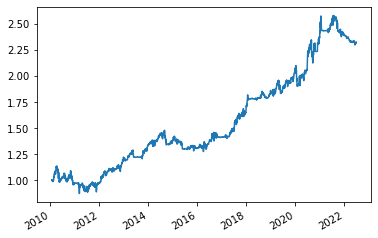

In [80]:
vaaCumReturn.plot()

### VAA 비중 함수

In [81]:
def getVAAWeight(closeDataSet):
    vaaCol = ['SPY', "VEA", "EEM", "AGG", "LQD", "SHY", "IEF"]
    vaaAttack = ['SPY', "VEA", "EEM", "AGG"]
    vaaDefense = ["LQD", "SHY", "IEF"]
    vaaData = closeDataSet[vaaCol]
    
    # 모멘텀 스코어를 구하기
    # (최근 1개월 수익률x12) + (최근 3개월 수익률x4) + (최근 6개월 수익률x2) + (최근 12개월 수익률x1)
    rebalDate = getRebalancingDate(vaaData)
    vaaDataOnRebalDate = vaaData.loc[rebalDate]

    momentum1 = vaaDataOnRebalDate / vaaDataOnRebalDate.shift(1) -1
    momentum3 = vaaDataOnRebalDate / vaaDataOnRebalDate.shift(3) - 1
    momentum6 = vaaDataOnRebalDate / vaaDataOnRebalDate.shift(6) -1
    momentum12 = vaaDataOnRebalDate / vaaDataOnRebalDate.shift(12) -1

    momentumScore = 12*momentum1 + 4*momentum3 + 2*momentum6 + momentum12
    momentumScore.dropna(inplace=True)
    
    # 공격자산 4개 모멘텀 스코어가 전부 0 초과일 경우 가장 모멘텀스코어가 높은 공격자산에 몰빵
    # 공격자산 중 하나라도 모멘텀스코어가 0 이하일 경우 가장 모멘텀스코어가 높은 수비자산에 몰빵
    isAttack = (momentumScore[vaaAttack] > 0).all(axis=1)
    vaaWeight = momentumScore.apply(applyGetVAAWegiht, axis=1)
    return vaaWeight
    
def applyGetVAAWegiht(row):
    if isAttack[row.name]:
        # 공격자산 중 가장 모멘텀 스코어가 높은 종목에 몰빵
        return pd.Series(row.index == row[vaaAttack].idxmax(), index=row.index, name=row.name).astype(int)

    # 수바자산 중 가장 모멘텀스코어가 높은 종목에 몰빵
    return pd.Series(row.index == row[vaaDefense].idxmax(), index=row.index, name=row.name).astype(int)

In [82]:
getVAAWeight(data)

,SPY,VEA,EEM,AGG,LQD,SHY,IEF
2010-01-29,0,0,0,0,1,0,0
2010-02-26,0,0,1,0,0,0,0
2010-03-31,0,0,1,0,0,0,0
2010-04-30,1,0,0,0,0,0,0
2010-05-28,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
2022-03-31,0,0,0,0,0,1,0
2022-04-29,0,0,0,0,0,1,0
2022-05-31,0,0,0,0,0,1,0
2022-06-30,0,0,0,0,0,1,0


## DAA (VAA 개선 버전)

투자 전략

---

1. 공격자산, 수비자산 설정

공격자산 : SPY(S&P500), IWM(러셀 2000), QQQ(나스닥), VGK(유럽 주식), EWJ(일본 주식), VWO(개발도상국 주식), VNQ(미국 리츠), GSG(원자재), GLD(금), TLT(미국 장기채), HYG(하이일드 채권), LQD(회사채)
 
수비자산 : SHY(미국 단기국채), IEF(미국 중기국채), UST(미국 중기채 레버리지)

2. 카나리아 자산 설정

카나리아 자산 : VWO(개발도상국 주식), BND(미국 총채권)

3. 모멘텀 스코어 계산

(최근 1개월 수익률x12) + (최근 3개월 수익률x4) + (최근 6개월 수익률x2) + (최근 12개월 수익률x1)

4. 카나리아 자산 모멘텀 스코어가 모두 0 이상일 때 공격 자산 중 모멘텀 스코어가 가장 큰 2개 자산을 보유

5. 카나리아 자산 중 하나의 자산만 모멘텀 스코어0 이상일 때 공격 자산 중 모멘텀 스코어가 가장 큰 2개 자산과 방어자산 1개

5. 카나리아 자산 중 하나라도 모멘텀스코어가 0 이하라면 수비 자산 중 모멘텀 스코어가 가장 큰 자산에 몰빵

In [83]:
# daaCol = ['SPY', "IWM", "QQQ", "VGK", "EWJ", "VWO", "VNQ", "GSG", "GLD", "TLT", "HYG", "LQD", "SHY", "IEF", "UST","BND"]
daaCol = ['SPY', "IWM", "QQQ", "VGK", "EWJ", "VWO", "VNQ", "GSG", "GLD", "TLT", "HYG", "LQD", "SHY", "IEF","BND"]
# daaAttack = ['SPY', "IWM", "QQQ", "VGK", "EWJ", "VWO", "VNQ", "GSG", "GLD", "TLT", "HYG", "LQD"]
daaAttack = ['SPY', "IWM", "QQQ", "VGK", "EWJ", "VWO", "VNQ", "GSG", "GLD", "HYG", "LQD"]

# 원래는 UST인데, TYD(중기채 3배 레버리지)로 해보자..
# daaDefense = [ "SHY", "IEF", "UST"] 
daaDefense = [ "SHY", "IEF", "TLT"] 
daaCanary = ["VWO", "BND"]

daaData = data[daaCol]
daaData.dropna(inplace=True)

### 모멘텀 스코어 계산

(최근 1개월 수익률x12) + (최근 3개월 수익률x4) + (최근 6개월 수익률x2) + (최근 12개월 수익률x1)

In [84]:
rebalDate

DatetimeIndex(['2009-01-30', '2009-02-27', '2009-03-31', '2009-04-30',
               '2009-05-29', '2009-06-30', '2009-07-31', '2009-08-31',
               '2009-09-30', '2009-10-30',
               ...
               '2021-10-29', '2021-11-30', '2021-12-31', '2022-01-31',
               '2022-02-28', '2022-03-31', '2022-04-29', '2022-05-31',
               '2022-06-30', '2022-07-01'],
              dtype='datetime64[ns]', length=163, freq=None)

In [85]:
rebalDate = getRebalancingDate(daaData)
daaDataOnRebalDate = daaData.loc[rebalDate]

momentum1 = daaDataOnRebalDate / daaDataOnRebalDate.shift(1) -1
momentum3 = daaDataOnRebalDate / daaDataOnRebalDate.shift(3) - 1
momentum6 = daaDataOnRebalDate / daaDataOnRebalDate.shift(6) -1
momentum12 = daaDataOnRebalDate / daaDataOnRebalDate.shift(12) -1

momentumScore = 12*momentum1 + 4*momentum3 + 2*momentum6 + momentum12
momentumScore.dropna(inplace=True)
momentumScore

,SPY,IWM,QQQ,VGK,EWJ,VWO,VNQ,GSG,GLD,TLT,HYG,LQD,SHY,IEF,BND
2010-01-29,0.256459,0.384538,0.065752,-0.308116,0.477950,0.317359,0.670668,-1.141503,0.413458,0.126380,0.335681,0.385464,0.151217,0.265636,0.339963
2010-02-26,1.141328,1.714132,1.547409,0.224417,0.649499,1.283355,2.260594,0.965066,0.702795,-0.336461,1.029482,0.289896,0.060500,-0.022881,0.181578
2010-03-31,1.685561,2.240035,2.023380,1.336952,1.351332,2.125673,3.128230,0.327873,0.419646,-0.506962,0.925043,0.397659,0.014054,-0.134470,0.126598
2010-04-30,1.331963,2.516934,1.731827,-0.055818,0.600274,1.182248,3.266433,1.136831,1.633006,0.373176,0.958518,0.614363,0.070622,0.239552,0.295530
2010-05-28,-0.772358,-0.041288,-0.412609,-2.082185,-1.152256,-1.070846,0.817873,-2.360321,1.003379,0.973092,-0.337878,0.045539,0.104322,0.578877,0.335825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31,0.464272,-0.386608,0.352562,-0.459067,-0.913363,-0.957656,0.736465,3.664342,0.708870,-1.291040,-0.574032,-0.963597,-0.371985,-0.939348,-0.786000
2022-04-29,-1.605514,-2.066041,-2.629701,-1.610959,-1.936030,-1.662277,-0.614165,2.721103,0.152494,-2.308065,-1.122855,-1.749928,-0.268668,-1.169049,-1.149679
2022-05-31,-0.390895,-0.809185,-1.144835,-0.170248,-0.548811,-0.705855,-0.842374,3.259768,-0.526166,-1.573824,-0.273550,-0.542052,-0.082974,-0.565008,-0.479735
2022-06-30,-2.225870,-2.471576,-2.797751,-2.674871,-2.203627,-1.484589,-2.135439,0.285607,-0.469991,-1.347097,-1.777399,-1.340754,-0.210631,-0.644808,-0.782449


In [86]:
isAttack = (momentumScore[daaCanary] > 0).sum(axis=1)

def applyGetDAAWeight(row):
    if isAttack[row.name] == 2:
        # 카나리아 자산 모멘텀 스코어가 모두 0 초과일 때 공격 자산 중 모멘텀 스코어가 가장 큰 2개 자산을 보유
        top2 = row[daaAttack].nlargest(n=2).index
        result = pd.Series(row.index.isin(top2), index=row.index, name=row.name).astype(int).replace(1, 0.5)
        return result
    
    if isAttack[row.name] == 1:
        # 카나리아 자산 중 하나의 자산만 모멘텀 스코어0 이상일 때 공격 자산 중 모멘텀 스코어가 가장 큰 자산과 방어자산
        topAttack = row[daaAttack].idxmax()
        topDefense = row[daaDefense].idxmax()
        result = pd.Series(row.index.isin([topAttack, topDefense]), index=row.index, name=row.name).astype(int).replace(1, 0.5)
        return result 
        
    # 카나리아 자산 중 하나라도 모멘텀스코어가 0 이하라면 수비 자산 중 모멘텀 스코어가 가장 큰 자산에 몰빵
    return pd.Series(row.index == row[daaDefense].idxmax(), index=row.index, name=row.name).astype(int)
    

daaWeight = momentumScore.apply(applyGetDAAWeight, axis=1)
daaWeight

,SPY,IWM,QQQ,VGK,EWJ,VWO,VNQ,GSG,GLD,TLT,HYG,LQD,SHY,IEF,BND
2010-01-29,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-02-26,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-03-31,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-04-30,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-05-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2022-04-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2022-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2022-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [87]:
daaDayReturn, daaCumReturn = getRebalancingPortfolioResult(closeDataSet=daaData, weightDf=daaWeight)
print("DAA 최종 수익률")
print(daaCumReturn.iloc[-1])
daaCagr, daaDD, daaMDD = getEvaluation(daaCumReturn)

DAA 최종 수익률
3.3648968166490363
cagr: 1.1026920562545965
mdd: 18.252476001245707


<AxesSubplot:>

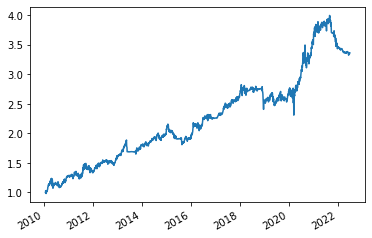

In [88]:
daaCumReturn.plot()

## DAA 비중 계산 함수화

In [89]:
def getDAAWeight(closeDataSet):
    
    daaCol = ['SPY', "IWM", "QQQ", "VGK", "EWJ", "VWO", "VNQ", "GSG", "GLD", "TLT", "HYG", "LQD", "SHY", "IEF","BND"]
    daaAttack = ['SPY', "IWM", "QQQ", "VGK", "EWJ", "VWO", "VNQ", "GSG", "GLD", "HYG", "LQD"]

    # UST 데이터 시점 문제로 TLT로 대체
    daaDefense = [ "SHY", "IEF", "TLT"] 
    daaCanary = ["VWO", "BND"]

    daaData = closeDataSet[daaCol]
    daaData.dropna(inplace=True)
    
    # 모멘텀 스코어 계산
    rebalDate = getRebalancingDate(daaData)
    daaDataOnRebalDate = daaData.loc[rebalDate]

    momentum1 = daaDataOnRebalDate / daaDataOnRebalDate.shift(1) -1
    momentum3 = daaDataOnRebalDate / daaDataOnRebalDate.shift(3) - 1
    momentum6 = daaDataOnRebalDate / daaDataOnRebalDate.shift(6) -1
    momentum12 = daaDataOnRebalDate / daaDataOnRebalDate.shift(12) -1

    momentumScore = 12*momentum1 + 4*momentum3 + 2*momentum6 + momentum12
    momentumScore.dropna(inplace=True)
    momentumScore
    
    # 카나리아 자산 모멘텀 스코어가 모두 0 이상일 때 공격 자산 중 모멘텀 스코어가 가장 큰 2개 자산을 보유
    # 카나리아 자산 중 하나의 자산만 모멘텀 스코어0 이상일 때 공격 자산 중 모멘텀 스코어가 가장 큰 2개 자산과 방어자산 1개
    # 카나리아 자산 중 하나라도 모멘텀스코어가 0 이하라면 수비 자산 중 모멘텀 스코어가 가장 큰 자산에 몰빵
    isAttack = (momentumScore[daaCanary] > 0).sum(axis=1)
    daaWeight = momentumScore.apply(applyGetDAAWeight, axis=1)
    return daaWeight
    
def applyGetDAAWeight(row):
    if isAttack[row.name] == 2:
        # 카나리아 자산 모멘텀 스코어가 모두 0 초과일 때 공격 자산 중 모멘텀 스코어가 가장 큰 2개 자산을 보유
        top2 = row[daaAttack].nlargest(n=2).index
        result = pd.Series(row.index.isin(top2), index=row.index, name=row.name).astype(int).replace(1, 0.5)
        return result
    
    if isAttack[row.name] == 1:
        # 카나리아 자산 중 하나의 자산만 모멘텀 스코어0 이상일 때 공격 자산 중 모멘텀 스코어가 가장 큰 자산과 방어자산
        topAttack = row[daaAttack].idxmax()
        topDefense = row[daaDefense].idxmax()
        result = pd.Series(row.index.isin([topAttack, topDefense]), index=row.index, name=row.name).astype(int).replace(1, 0.5)
        return result 
        
    # 카나리아 자산 중 하나라도 모멘텀스코어가 0 이하라면 수비 자산 중 모멘텀 스코어가 가장 큰 자산에 몰빵
    return pd.Series(row.index == row[daaDefense].idxmax(), index=row.index, name=row.name).astype(int)

In [90]:
daaWeight = getDAAWeight()

TypeError: getDAAWeight() missing 1 required positional argument: 'closeDataSet'

In [ ]:
daaWeight

# DAA 방어자산에 현금 추가